<a href="https://colab.research.google.com/github/rahuls569/EVA8/blob/main/Assignment%205/ASSIGNMENT5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Availalbe?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model

In [ ]:
import torch.nn.functional as F
# dropout_value = 0.1
# num_groups =2
norm_type='GN'
class Net(nn.Module):
    def __init__(self, norm_type='GN', dropout_value = 0.1, num_groups =2):
        super(Net, self).__init__()
        self.norm_type= norm_type
        
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        if self.norm_type == 'GN':
            self.convblock2.add_module('norm', nn.GroupNorm(num_groups, num_channels=16))
        elif self.norm_type == 'LN':
            self.convblock2.add_module('norm', nn.LayerNorm([16, 24, 24]))
        elif self.norm_type == 'BN':
            self.convblock2.add_module('norm', nn.BatchNorm2d(16))

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
           
            nn.Dropout(dropout_value)
        ) # output_size = 10

        if self.norm_type == 'GN':
            self.convblock4.add_module('norm', nn.GroupNorm(num_groups, num_channels=16))
        elif self.norm_type == 'LN':
            self.convblock4.add_module('norm', nn.LayerNorm([16, 10, 10]))
        elif self.norm_type == 'BN':
            self.convblock4.add_module('norm', nn.BatchNorm2d(16))       




        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            
            nn.Dropout(dropout_value)
        ) # output_size = 8

        if self.norm_type == 'GN':
            self.convblock5.add_module('norm', nn.GroupNorm(num_groups, num_channels=8))
        elif self.norm_type == 'LN':
            self.convblock5.add_module('norm', nn.LayerNorm([8, 8, 8]))
        elif self.norm_type == 'BN':
            self.convblock5.add_module('norm', nn.BatchNorm2d(8))      

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
           
            nn.Dropout(dropout_value)
        ) # output_size = 6

        if self.norm_type == 'GN':
            self.convblock6.add_module('norm', nn.GroupNorm(num_groups, num_channels=16))
        elif self.norm_type == 'LN':
            self.convblock6.add_module('norm', nn.LayerNorm([16, 6, 6]))
        elif self.norm_type == 'BN':
            self.convblock6.add_module('norm', nn.BatchNorm2d(16))      


        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
           
            nn.Dropout(dropout_value)
        ) # output_size = 4

        if self.norm_type == 'GN':
            self.convblock7.add_module('norm', nn.GroupNorm(num_groups, num_channels=16))
        elif self.norm_type == 'LN':
            self.convblock7.add_module('norm', nn.LayerNorm([16, 4, 4]))
        elif self.norm_type == 'BN':
            self.convblock7.add_module('norm', nn.BatchNorm2d(16))  
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)

        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1,10)

        return F.log_softmax(x, dim=-1)

## Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
norm_type='BN'
t=norm_type
model = Net(t).to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
           Dropout-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7            [-1, 8, 24, 24]             128
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           1,152
             ReLU-10           [-1, 16, 10, 10]               0
          Dropout-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32

## Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, t, lamda_l1):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())
    if(t=='BN'):
      l1=0
      for p in model.parameters():
        l1=l1+p.abs().sum()
        loss= loss+ lamda_l1* l1         

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
                        # compare predictions with true label
            for i, (p, t) in enumerate(zip(pred, target)):
                if p != t:
                    misclassified_images.append((data[i], p, t))
            
            
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return misclassified_images

In [ ]:
from torch.optim.lr_scheduler import StepLR
model =  Net(t).to(device)
if t=='BN':
   optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
else:
    optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
lamda_l1=0.0001
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, t, lamda_l1)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.4332024157047272 Batch_id=468 Accuracy=87.82: 100%|██████████| 469/469 [00:23<00:00, 19.61it/s]



Test set: Average loss: 0.1148, Accuracy: 9678/10000 (96.78%)

EPOCH: 1


Loss=0.436767578125 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]



Test set: Average loss: 0.0700, Accuracy: 9781/10000 (97.81%)

EPOCH: 2


Loss=0.3071940839290619 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:18<00:00, 25.58it/s]



Test set: Average loss: 0.0630, Accuracy: 9807/10000 (98.07%)

EPOCH: 3


Loss=0.28300610184669495 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]



Test set: Average loss: 0.0839, Accuracy: 9731/10000 (97.31%)

EPOCH: 4


Loss=0.26455527544021606 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:19<00:00, 24.09it/s]



Test set: Average loss: 0.0839, Accuracy: 9740/10000 (97.40%)

EPOCH: 5


Loss=0.380510151386261 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s]



Test set: Average loss: 0.0624, Accuracy: 9804/10000 (98.04%)

EPOCH: 6


Loss=0.1716189831495285 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]



Test set: Average loss: 0.0284, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.1920030415058136 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0273, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.23486509919166565 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:18<00:00, 25.33it/s]



Test set: Average loss: 0.0285, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.17980244755744934 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:18<00:00, 25.60it/s]



Test set: Average loss: 0.0262, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.16189709305763245 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:18<00:00, 25.29it/s]



Test set: Average loss: 0.0284, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.16423925757408142 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]



Test set: Average loss: 0.0257, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.13610440492630005 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:18<00:00, 24.93it/s]



Test set: Average loss: 0.0241, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.13160468637943268 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]



Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.17294806241989136 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]



Test set: Average loss: 0.0240, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.14774377644062042 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:18<00:00, 25.30it/s]



Test set: Average loss: 0.0233, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.1644803285598755 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]



Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.13940279185771942 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:19<00:00, 23.89it/s]



Test set: Average loss: 0.0230, Accuracy: 9924/10000 (99.24%)

EPOCH: 18


Loss=0.16310852766036987 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:18<00:00, 25.78it/s]



Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.22998741269111633 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:18<00:00, 25.78it/s]



Test set: Average loss: 0.0230, Accuracy: 9928/10000 (99.28%)



In [ ]:
if t == 'GN':
  train_losses_GN=train_losses
  train_acc_GN=train_acc[4000:] 
  test_losses_GN=test_losses
  test_acc_GN = test_acc
elif t=='BN':
  train_losses_BN=train_losses
  train_acc_BN=train_acc[4000:] 
  test_losses_BN=test_losses
  test_acc_BN = test_acc
elif t=='LN':
  train_losses_LN=train_losses
  train_acc_LN=train_acc[4000:] 
  test_losses_LN=test_losses
  test_acc_LN = test_acc
t

'BN'


Test set: Average loss: 0.0230, Accuracy: 9928/10000 (99.28%)



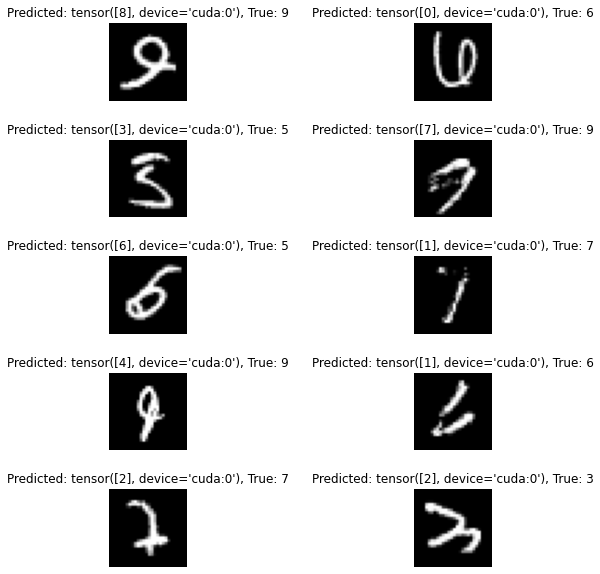

In [ ]:
import matplotlib.pyplot as plt

misclassified_images = test(model, device, test_loader)

fig, axs = plt.subplots(5, 2, figsize=(10,10))
axs = axs.ravel()

for i, (img, pred, true) in enumerate(misclassified_images[:10]):
    axs[i].imshow(img.cpu().squeeze(), cmap='gray')
    axs[i].set_title(f'Predicted: {pred}, True: {true}')
    axs[i].axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()

/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  func(*args, **kwargs)


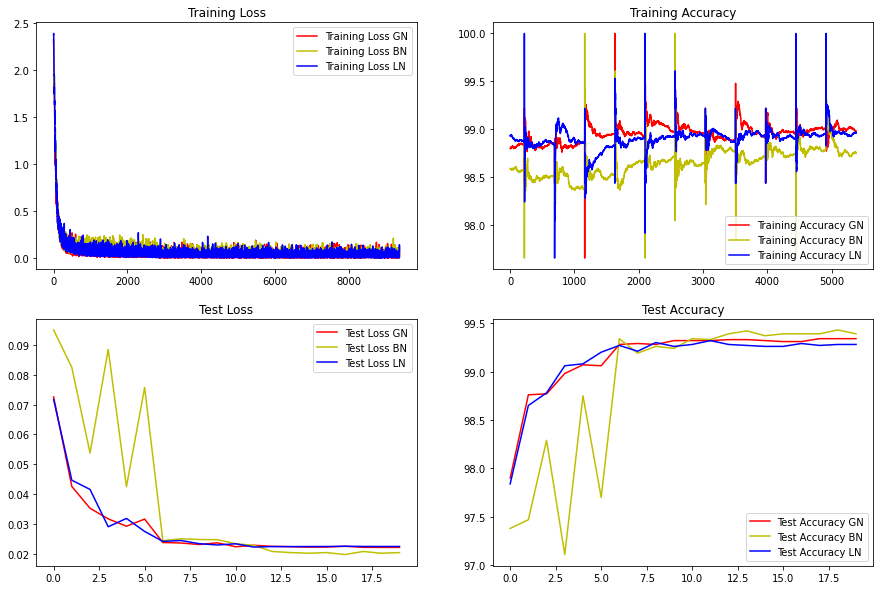

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_GN, color='r', label='Training Loss GN')
axs[0, 0].plot(train_losses_BN, color='y', label='Training Loss BN')
axs[0, 0].plot(train_losses_LN, color='B', label='Training Loss LN')
axs[0, 0].set_title("Training Loss")
axs[0, 0].legend()

axs[0, 1].plot(train_acc_GN, color='r', label='Training Accuracy GN')
axs[0, 1].plot(train_acc_BN, color='y', label='Training Accuracy BN')
axs[0, 1].plot(train_acc_LN, color='B', label='Training Accuracy LN')
axs[0, 1].set_title("Training Accuracy")
axs[0, 1].legend()

axs[1, 0].plot(test_losses_GN, color='r', label='Test Loss GN')
axs[1, 0].plot(test_losses_BN, color='y', label='Test Loss BN')
axs[1, 0].plot(test_losses_LN, color='B', label='Test Loss LN')
axs[1, 0].set_title("Test Loss")
axs[1, 0].legend()

axs[1, 1].plot(test_acc_GN, color='r', label='Test Accuracy GN')
axs[1, 1].plot(test_acc_BN, color='y', label='Test Accuracy BN')
axs[1, 1].plot(test_acc_LN, color='B', label='Test Accuracy LN')
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].legend()
